# Load Package and Data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, weibull_min, kstest, cramervonmises, anderson_ksamp
from scipy.special import gamma, gammainc, erf, betainc, betaln
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Load data

In [2]:
data = pd.read_csv('../Data/M7 Declustering.csv')
u = 5.65
e = 0.00001

# Lognormal-GPD

In [3]:
def log_likelihood_lognormal_gpd(params, data, u):
    mu, sigma_logn, xi, sigma_gpd = params
    if sigma_logn <= 0 or sigma_gpd <= 0:
        return np.inf  # invalid parameter
    
    below_u = data[data < u]
    above_u = data[data >= u]
    
    # Lognormal part
    z = (np.log(below_u) - mu) / sigma_logn
    ll_logn = np.sum(-np.log(below_u * sigma_logn * np.sqrt(2 * np.pi)) - 0.5 * z**2)
    
    # GPD part
    if xi != 0:
        ll_gpd = np.sum(
            np.log(1 - norm.cdf((np.log(u) - mu) / sigma_logn)) - np.log(sigma_gpd) +
            (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
        )
    else:
        ll_gpd = np.sum(
            np.log(1 - norm.cdf((np.log(u) - mu) / sigma_logn)) - np.log(sigma_gpd) -
            (above_u - u) / sigma_gpd
        )
    return -(ll_logn + ll_gpd)  # negative for minimization

def estimate_lognormal_gpd(data, u):
    mu0 = np.mean(np.log(data[data < u]))
    sigma_logn0 = np.std(np.log(data[data < u]))
    xi0 = 0.1
    sigma_gpd0 = np.std(data[data >= u])
    
    bounds = [
        (None, None),      # mu
        (1e-6, None),      # sigma_logn
        (-1, 1),           # xi
        (1e-6, None)       # sigma_gpd
    ]
    
    result = minimize(
        log_likelihood_lognormal_gpd,
        x0=[mu0, sigma_logn0, xi0, sigma_gpd0],
        args=(data, u),
        bounds=bounds,
        method='L-BFGS-B'
    )
    mu, sigma_logn, xi, sigma_gpd = result.x
    print("Estimasi Parameter Lognormal-GPD")
    print("Parameter Lognormal:")
    print(f"\\mu (lokasi) = {mu:.4f}")
    print(f"\\sigma (skala) = {sigma_logn:.4f}")
    print("Parameter GPD:")
    print(f"u (threshold) = {u:.4f}")
    print(f"\\xi (bentuk) = {xi:.4f}")
    print(f"\\sigma (skala) = {sigma_gpd:.4f}")
    return mu, sigma_logn, xi, sigma_gpd

def logn_comp_cdf(x, mu, sigma_logn, xi, sigma_gpd, u):
    # CDF komposit lognormal-GPD
    cdf_logn = norm.cdf((np.log(np.minimum(x, u)) - mu) / sigma_logn)
    if np.isscalar(x):
        if x < u:
            return cdf_logn
        else:
            if xi != 0:
                cdf_gpd = 1 - (1 - norm.cdf((np.log(u) - mu) / sigma_logn)) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi)
            else:
                cdf_gpd = 1 - (1 - norm.cdf((np.log(u) - mu) / sigma_logn)) * np.exp(-(x - u) / sigma_gpd)
            return cdf_gpd
    else:
        cdf = np.where(
            x < u,
            cdf_logn,
            np.where(
                xi != 0,
                1 - (1 - norm.cdf((np.log(u) - mu) / sigma_logn)) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi),
                1 - (1 - norm.cdf((np.log(u) - mu) / sigma_logn)) * np.exp(-(x - u) / sigma_gpd)
            )
        )
        return cdf

Estimasi Parameter Lognormal-GPD
Parameter Lognormal:
\mu (lokasi) = 1.5829
\sigma (skala) = 0.0906
Parameter GPD:
u (threshold) = 5.6500
\xi (bentuk) = 0.1724
\sigma (skala) = 0.4426
                               time  latitude  longitude  depth   mag magType  \
0  2019-08-02 12:03:27.001000+00:00   -7.2822   104.7907   49.0  6.90      mw   
1  1954-07-03 22:31:27.020000+00:00   -6.6240   105.4470   60.0  6.82      mw   
2  1913-08-13 04:25:42.330000+00:00   -6.7460   105.2130   35.0  6.63      mw   
3  2022-01-14 09:05:41.461000+00:00   -6.8600   105.2887   33.0  6.60      mw   
4  1999-12-21 14:14:57.610000+00:00   -6.8450   105.5550   56.0  6.50      mw   

   nst   gap   dmin   rms  ... depthError magError magNst    status  \
0  NaN  23.0  2.839  0.76  ...        1.9    0.043   51.0  reviewed   
1  NaN   NaN    NaN   NaN  ...        5.2    0.430    NaN  reviewed   
2  NaN   NaN    NaN   NaN  ...       30.2    0.230    NaN  reviewed   
3  NaN  22.0  2.418  0.54  ...        1.7    

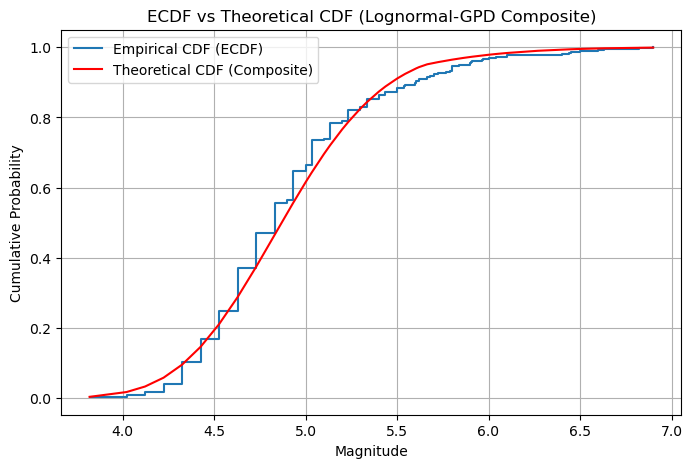

In [4]:
mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd = estimate_lognormal_gpd(data['mag'].values, u)

data['event rate'] = logn_comp_cdf(data['mag'] + e, mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd, u) - \
                     logn_comp_cdf(data['mag'] - e, mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd, u)

print(data.head())

# Plot ECDF vs Theoretical CDF
mag_sorted = np.sort(data['mag'])
ecdf = np.arange(1, len(mag_sorted)+1) / len(mag_sorted)
theoretical_cdf = logn_comp_cdf(mag_sorted, mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd, u)

plt.figure(figsize=(8,5))
plt.step(mag_sorted, ecdf, where='post', label='Empirical CDF (ECDF)')
plt.plot(mag_sorted, theoretical_cdf, 'r-', label='Theoretical CDF (Composite)')
plt.xlabel('Magnitude')
plt.ylabel('Cumulative Probability')
plt.title('ECDF vs Theoretical CDF (Lognormal-GPD Composite)')
plt.legend()
plt.grid(True)
plt.show()

# Weibull-GPD

In [5]:
def log_likelihood_weibull_gpd(params, data, u):
    theta, tau, xi, sigma_gpd = params
    if theta <= 0 or tau <= 0 or sigma_gpd <= 0:
        return np.inf  # invalid parameter
    
    below_u = data[data < u]
    above_u = data[data >= u]
    
    # Weibull part
    ll_weibull = np.sum(
        (tau * (below_u / theta) ** tau * np.exp(-(below_u / theta) ** tau)) / below_u
    )
    ll_weibull = np.sum(
        np.log(tau) + tau * np.log(below_u / theta) - (below_u / theta) ** tau - np.log(below_u)
    )
    
    # GPD part
    weibull_cdf_u = 1 - np.exp(-(u / theta) ** tau)
    if xi != 0:
        ll_gpd = np.sum(
            np.log(1 - weibull_cdf_u) - np.log(sigma_gpd) +
            (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
        )
    else:
        ll_gpd = np.sum(
            np.log(1 - weibull_cdf_u) - np.log(sigma_gpd) -
            (above_u - u) / sigma_gpd
        )
    return -(ll_weibull + ll_gpd)  # negative for minimization

def estimate_weibull_gpd(data, u):
    # Initial guess: theta, tau, xi, sigma_gpd
    theta0 = np.median(data[data < u])
    tau0 = 1.5
    xi0 = 0.1
    sigma_gpd0 = np.std(data[data >= u])
    
    bounds = [
        (1e-6, None),      # theta (skala Weibull)
        (1e-6, None),      # tau (bentuk Weibull)
        (-1, 1),           # xi (bentuk GPD)
        (1e-6, None)       # sigma_gpd (skala GPD)
    ]
    
    result = minimize(
        log_likelihood_weibull_gpd,
        x0=[theta0, tau0, xi0, sigma_gpd0],
        args=(data, u),
        bounds=bounds,
        method='L-BFGS-B'
    )
    theta, tau, xi, sigma_gpd = result.x
    print("Estimasi Parameter Weibull-GPD")
    print("Parameter Weibull:")
    print(f"\\theta (skala) = {theta:.4f}")
    print(f"\\tau (bentuk) = {tau:.4f}")
    print("Parameter GPD:")
    print(f"u (threshold) = {u:.4f}")
    print(f"\\xi (bentuk) = {xi:.4f}")
    print(f"\\sigma (skala) = {sigma_gpd:.4f}")
    return theta, tau, xi, sigma_gpd

def weibull_comp_cdf(x, theta, tau, xi, sigma_gpd, u):
    # CDF komposit Weibull-GPD
    weibull_cdf = 1 - np.exp(-(np.minimum(x, u) / theta) ** tau)
    if np.isscalar(x):
        if x < u:
            return weibull_cdf
        else:
            cdf_u = 1 - np.exp(-(u / theta) ** tau)
            if xi != 0:
                cdf_gpd = 1 - (1 - cdf_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi)
            else:
                cdf_gpd = 1 - (1 - cdf_u) * np.exp(-(x - u) / sigma_gpd)
            return cdf_gpd
    else:
        cdf_u = 1 - np.exp(-(u / theta) ** tau)
        cdf = np.where(
            x < u,
            weibull_cdf,
            np.where(
                xi != 0,
                1 - (1 - cdf_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi),
                1 - (1 - cdf_u) * np.exp(-(x - u) / sigma_gpd)
            )
        )
        return cdf

C:\Users\user\AppData\Local\Temp\ipykernel_7212\1700967120.py:22: RuntimeWarning: invalid value encountered in log
  (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)


Estimasi Parameter Weibull-GPD
Parameter Weibull:
\theta (skala) = 4.8048
\tau (bentuk) = 2.4911
Parameter GPD:
u (threshold) = 5.6500
\xi (bentuk) = 0.0951
\sigma (skala) = 0.4558
                               time  latitude  longitude  depth   mag magType  \
0  2019-08-02 12:03:27.001000+00:00   -7.2822   104.7907   49.0  6.90      mw   
1  1954-07-03 22:31:27.020000+00:00   -6.6240   105.4470   60.0  6.82      mw   
2  1913-08-13 04:25:42.330000+00:00   -6.7460   105.2130   35.0  6.63      mw   
3  2022-01-14 09:05:41.461000+00:00   -6.8600   105.2887   33.0  6.60      mw   
4  1999-12-21 14:14:57.610000+00:00   -6.8450   105.5550   56.0  6.50      mw   

   nst   gap   dmin   rms  ... depthError magError magNst    status  \
0  NaN  23.0  2.839  0.76  ...        1.9    0.043   51.0  reviewed   
1  NaN   NaN    NaN   NaN  ...        5.2    0.430    NaN  reviewed   
2  NaN   NaN    NaN   NaN  ...       30.2    0.230    NaN  reviewed   
3  NaN  22.0  2.418  0.54  ...        1.7    0.0

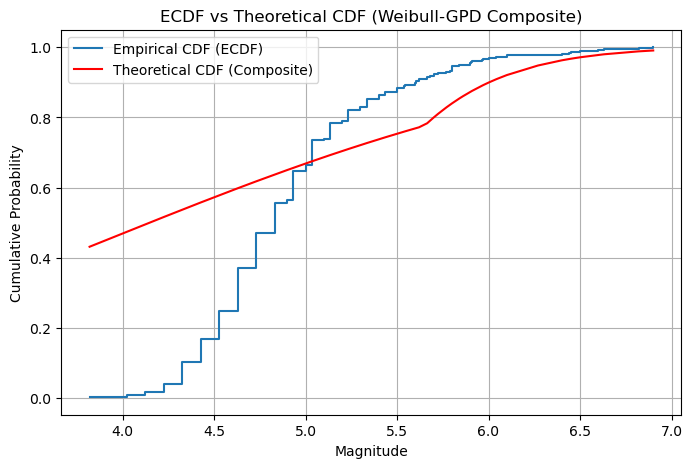

In [6]:
theta_wei, tau_wei, xi_wei_gpd, sigma_wei_gpd = estimate_weibull_gpd(data['mag'].values, u)

data['event rate'] = weibull_comp_cdf(data['mag'] + e, theta_wei, tau_wei, xi_wei_gpd, sigma_wei_gpd, u) - \
                     weibull_comp_cdf(data['mag'] - e, theta_wei, tau_wei, xi_wei_gpd, sigma_wei_gpd, u)

print(data.head())

# Plot ECDF vs Theoretical CDF
mag_sorted = np.sort(data['mag'])
ecdf = np.arange(1, len(mag_sorted)+1) / len(mag_sorted)
theoretical_cdf = weibull_comp_cdf(mag_sorted, theta_wei, tau_wei, xi_wei_gpd, sigma_wei_gpd, u)

plt.figure(figsize=(8,5))
plt.step(mag_sorted, ecdf, where='post', label='Empirical CDF (ECDF)')
plt.plot(mag_sorted, theoretical_cdf, 'r-', label='Theoretical CDF (Composite)')
plt.xlabel('Magnitude')
plt.ylabel('Cumulative Probability')
plt.title('ECDF vs Theoretical CDF (Weibull-GPD Composite)')
plt.legend()
plt.grid(True)
plt.show()

# Gamma-GPD

In [7]:
def log_likelihood_gamma_gpd(params, data, u):
    theta, alpha, xi, sigma_gpd = params
    if theta <= 0 or alpha <= 0 or sigma_gpd <= 0:
        return np.inf  # invalid parameter
    
    below_u = data[data < u]
    above_u = data[data >= u]
    
    # Gamma part
    ll_gamma = np.sum(
        alpha * np.log(below_u / theta) - below_u / theta - np.log(below_u) - np.log(gamma(alpha))
    )
    
    # GPD part
    gamma_cdf_u = gammainc(alpha, u / theta)
    if xi != 0:
        ll_gpd = np.sum(
            np.log(1 - gamma_cdf_u) - np.log(sigma_gpd) +
            (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
        )
    else:
        ll_gpd = np.sum(
            np.log(1 - gamma_cdf_u) - np.log(sigma_gpd) -
            (above_u - u) / sigma_gpd
        )
    return -(ll_gamma + ll_gpd)  # negative for minimization

def estimate_gamma_gpd(data, u):
    # Initial guess: theta, alpha, xi, sigma_gpd
    theta0 = np.mean(data[data < u]) / 2
    alpha0 = 2.0
    xi0 = 0.1
    sigma_gpd0 = np.std(data[data >= u])
    
    bounds = [
        (1e-6, None),      # theta (skala Gamma)
        (1e-6, None),      # alpha (bentuk Gamma)
        (-1, 1),           # xi (bentuk GPD)
        (1e-6, None)       # sigma_gpd (skala GPD)
    ]
    
    result = minimize(
        log_likelihood_gamma_gpd,
        x0=[theta0, alpha0, xi0, sigma_gpd0],
        args=(data, u),
        bounds=bounds,
        method='L-BFGS-B'
    )
    theta, alpha, xi, sigma_gpd = result.x
    print("Estimasi Parameter Gamma-GPD")
    print("Parameter Gamma:")
    print(f"\\theta (skala) = {theta:.4f}")
    print(f"\\alpha (bentuk) = {alpha:.4f}")
    print("Parameter GPD:")
    print(f"u (threshold) = {u:.4f}")
    print(f"\\xi (bentuk) = {xi:.4f}")
    print(f"\\sigma (skala) = {sigma_gpd:.4f}")
    return theta, alpha, xi, sigma_gpd

def gamma_comp_cdf(x, theta, alpha, xi, sigma_gpd, u):
    # CDF komposit Gamma-GPD
    from scipy.special import gammainc
    gamma_cdf = gammainc(alpha, np.minimum(x, u) / theta)
    if np.isscalar(x):
        if x < u:
            return gamma_cdf
        else:
            cdf_u = gammainc(alpha, u / theta)
            if xi != 0:
                cdf_gpd = 1 - (1 - cdf_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi)
            else:
                cdf_gpd = 1 - (1 - cdf_u) * np.exp(-(x - u) / sigma_gpd)
            return cdf_gpd
    else:
        cdf_u = gammainc(alpha, u / theta)
        cdf = np.where(
            x < u,
            gamma_cdf,
            np.where(
                xi != 0,
                1 - (1 - cdf_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi),
                1 - (1 - cdf_u) * np.exp(-(x - u) / sigma_gpd)
            )
        )
        return cdf

C:\Users\user\AppData\Local\Temp\ipykernel_7212\175231378.py:18: RuntimeWarning: divide by zero encountered in log
  np.log(1 - gamma_cdf_u) - np.log(sigma_gpd) +
C:\Users\user\AppData\Local\Temp\ipykernel_7212\175231378.py:19: RuntimeWarning: invalid value encountered in log
  (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
c:\Users\user\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Estimasi Parameter Gamma-GPD
Parameter Gamma:
\theta (skala) = 1.7199
\alpha (bentuk) = 3.0093
Parameter GPD:
u (threshold) = 5.6500
\xi (bentuk) = 0.1483
\sigma (skala) = 0.4203
                               time  latitude  longitude  depth   mag magType  \
0  2019-08-02 12:03:27.001000+00:00   -7.2822   104.7907   49.0  6.90      mw   
1  1954-07-03 22:31:27.020000+00:00   -6.6240   105.4470   60.0  6.82      mw   
2  1913-08-13 04:25:42.330000+00:00   -6.7460   105.2130   35.0  6.63      mw   
3  2022-01-14 09:05:41.461000+00:00   -6.8600   105.2887   33.0  6.60      mw   
4  1999-12-21 14:14:57.610000+00:00   -6.8450   105.5550   56.0  6.50      mw   

   nst   gap   dmin   rms  ... depthError magError magNst    status  \
0  NaN  23.0  2.839  0.76  ...        1.9    0.043   51.0  reviewed   
1  NaN   NaN    NaN   NaN  ...        5.2    0.430    NaN  reviewed   
2  NaN   NaN    NaN   NaN  ...       30.2    0.230    NaN  reviewed   
3  NaN  22.0  2.418  0.54  ...        1.7    0.063

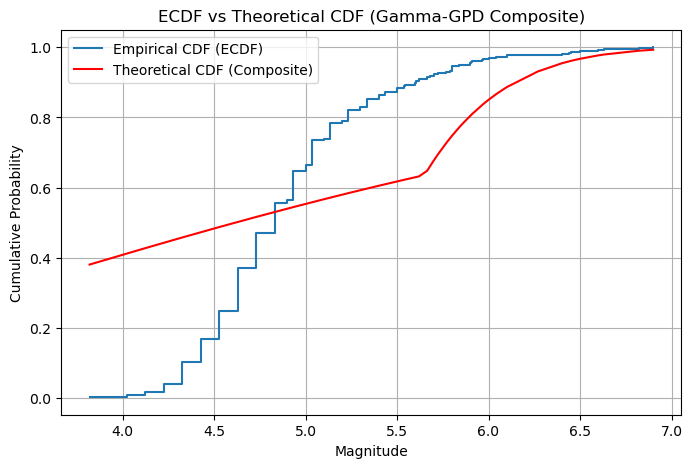

In [8]:
theta_gam, alpha_gam, xi_gam_gpd, sigma_gam_gpd = estimate_gamma_gpd(data['mag'].values, u)

data['event rate'] = gamma_comp_cdf(data['mag'] + e, theta_gam, alpha_gam, xi_gam_gpd, sigma_gam_gpd, u) - \
                     gamma_comp_cdf(data['mag'] - e, theta_gam, alpha_gam, xi_gam_gpd, sigma_gam_gpd, u)

print(data.head())

# Plot ECDF vs Theoretical CDF
mag_sorted = np.sort(data['mag'])
ecdf = np.arange(1, len(mag_sorted)+1) / len(mag_sorted)
theoretical_cdf = gamma_comp_cdf(mag_sorted, theta_gam, alpha_gam, xi_gam_gpd, sigma_gam_gpd, u)

plt.figure(figsize=(8,5))
plt.step(mag_sorted, ecdf, where='post', label='Empirical CDF (ECDF)')
plt.plot(mag_sorted, theoretical_cdf, 'r-', label='Theoretical CDF (Composite)')
plt.xlabel('Magnitude')
plt.ylabel('Cumulative Probability')
plt.title('ECDF vs Theoretical CDF (Gamma-GPD Composite)')
plt.legend()
plt.grid(True)
plt.show()

# Loglogistic-GPD

In [9]:
def log_likelihood_loglogistic_gpd(params, data, u):
    theta, gamma, xi, sigma_gpd = params
    if theta <= 0 or gamma <= 0 or sigma_gpd <= 0:
        return np.inf  # invalid parameter
    
    below_u = data[data < u]
    above_u = data[data >= u]
    
    # Loglogistic part
    ll_loglog = np.sum(
        np.log(gamma) + gamma * np.log(below_u / theta) - np.log(below_u) - 2 * np.log(1 + (below_u / theta) ** gamma)
    )
    
    # CDF loglogistic di u
    F_u = (u / theta) ** gamma / (1 + (u / theta) ** gamma)
    
    # GPD part
    if xi != 0:
        ll_gpd = np.sum(
            np.log(1 - F_u) - np.log(sigma_gpd) +
            (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
        )
    else:
        ll_gpd = np.sum(
            np.log(1 - F_u) - np.log(sigma_gpd) -
            (above_u - u) / sigma_gpd
        )
    return -(ll_loglog + ll_gpd)  # negative for minimization

def estimate_loglogistic_gpd(data, u):
    theta0 = np.median(data[data < u])
    gamma0 = 1.5
    xi0 = 0.1
    sigma_gpd0 = np.std(data[data >= u])
    
    bounds = [
        (1e-6, None),      # theta (skala Loglogistic)
        (1e-6, None),      # gamma (bentuk Loglogistic)
        (-1, 1),           # xi (bentuk GPD)
        (1e-6, None)       # sigma_gpd (skala GPD)
    ]
    
    result = minimize(
        log_likelihood_loglogistic_gpd,
        x0=[theta0, gamma0, xi0, sigma_gpd0],
        args=(data, u),
        bounds=bounds,
        method='L-BFGS-B'
    )
    theta, gamma, xi, sigma_gpd = result.x
    print("Estimasi Parameter Loglogistic-GPD")
    print("Parameter Loglogistic:")
    print(f"\\theta (skala) = {theta:.4f}")
    print(f"\\gamma (bentuk) = {gamma:.4f}")
    print("Parameter GPD:")
    print(f"u (threshold) = {u:.4f}")
    print(f"\\xi (bentuk) = {xi:.4f}")
    print(f"\\sigma (skala) = {sigma_gpd:.4f}")
    return theta, gamma, xi, sigma_gpd

def loglogistic_comp_cdf(x, theta, gamma, xi, sigma_gpd, u):
    # CDF komposit Loglogistic-GPD
    F = (np.minimum(x, u) / theta) ** gamma / (1 + (np.minimum(x, u) / theta) ** gamma)
    if np.isscalar(x):
        if x < u:
            return F
        else:
            F_u = (u / theta) ** gamma / (1 + (u / theta) ** gamma)
            if xi != 0:
                cdf_gpd = 1 - (1 - F_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi)
            else:
                cdf_gpd = 1 - (1 - F_u) * np.exp(-(x - u) / sigma_gpd)
            return cdf_gpd
    else:
        F_u = (u / theta) ** gamma / (1 + (u / theta) ** gamma)
        cdf = np.where(
            x < u,
            F,
            np.where(
                xi != 0,
                1 - (1 - F_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi),
                1 - (1 - F_u) * np.exp(-(x - u) / sigma_gpd)
            )
        )
        return cdf

Estimasi Parameter Loglogistic-GPD
Parameter Loglogistic:
\theta (skala) = 4.7605
\gamma (bentuk) = 2.4937
Parameter GPD:
u (threshold) = 5.6500
\xi (bentuk) = 0.0952
\sigma (skala) = 0.4531
                               time  latitude  longitude  depth   mag magType  \
0  2019-08-02 12:03:27.001000+00:00   -7.2822   104.7907   49.0  6.90      mw   
1  1954-07-03 22:31:27.020000+00:00   -6.6240   105.4470   60.0  6.82      mw   
2  1913-08-13 04:25:42.330000+00:00   -6.7460   105.2130   35.0  6.63      mw   
3  2022-01-14 09:05:41.461000+00:00   -6.8600   105.2887   33.0  6.60      mw   
4  1999-12-21 14:14:57.610000+00:00   -6.8450   105.5550   56.0  6.50      mw   

   nst   gap   dmin   rms  ... depthError magError magNst    status  \
0  NaN  23.0  2.839  0.76  ...        1.9    0.043   51.0  reviewed   
1  NaN   NaN    NaN   NaN  ...        5.2    0.430    NaN  reviewed   
2  NaN   NaN    NaN   NaN  ...       30.2    0.230    NaN  reviewed   
3  NaN  22.0  2.418  0.54  ...        

C:\Users\user\AppData\Local\Temp\ipykernel_7212\2099268052.py:21: RuntimeWarning: invalid value encountered in log
  (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)


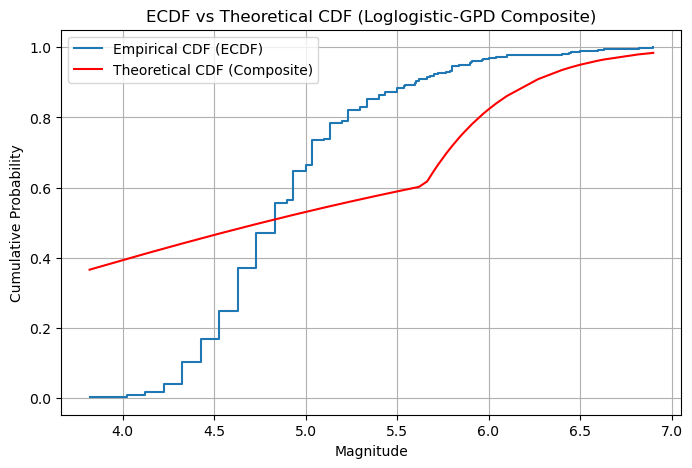

In [10]:
theta_logl, gamma_logl, xi_logl_gpd, sigma_logl_gpd = estimate_loglogistic_gpd(data['mag'].values, u)

data['event rate'] = loglogistic_comp_cdf(data['mag'] + e, theta_logl, gamma_logl, xi_logl_gpd, sigma_logl_gpd, u) - \
                     loglogistic_comp_cdf(data['mag'] - e, theta_logl, gamma_logl, xi_logl_gpd, sigma_logl_gpd, u)

print(data.head())

# Plot ECDF vs Theoretical CDF
mag_sorted = np.sort(data['mag'])
ecdf = np.arange(1, len(mag_sorted)+1) / len(mag_sorted)
theoretical_cdf = loglogistic_comp_cdf(mag_sorted, theta_logl, gamma_logl, xi_logl_gpd, sigma_logl_gpd, u)

plt.figure(figsize=(8,5))
plt.step(mag_sorted, ecdf, where='post', label='Empirical CDF (ECDF)')
plt.plot(mag_sorted, theoretical_cdf, 'r-', label='Theoretical CDF (Composite)')
plt.xlabel('Magnitude')
plt.ylabel('Cumulative Probability')
plt.title('ECDF vs Theoretical CDF (Loglogistic-GPD Composite)')
plt.legend()
plt.grid(True)
plt.show()

# Normal-GPD

In [11]:
def log_likelihood_normal_gpd(params, data, u):
    mu, sigma, xi, sigma_gpd = params
    if sigma <= 0 or sigma_gpd <= 0:
        return np.inf  # invalid parameter
    
    below_u = data[data < u]
    above_u = data[data >= u]
    
    # Normal part
    ll_norm = np.sum(
        -np.log(sigma * np.sqrt(2 * np.pi)) - ((below_u - mu) ** 2) / (2 * sigma ** 2)
    )
    
    # CDF normal di u
    norm_cdf_u = 0.5 * (1 + erf((u - mu) / (sigma * np.sqrt(2))))
    
    # GPD part
    if xi != 0:
        ll_gpd = np.sum(
            np.log(1 - norm_cdf_u) - np.log(sigma_gpd) +
            (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
        )
    else:
        ll_gpd = np.sum(
            np.log(1 - norm_cdf_u) - np.log(sigma_gpd) -
            (above_u - u) / sigma_gpd
        )
    return -(ll_norm + ll_gpd)  # negative for minimization

def estimate_normal_gpd(data, u):
    mu0 = np.mean(data[data < u])
    sigma0 = np.std(data[data < u])
    xi0 = 0.1
    sigma_gpd0 = np.std(data[data >= u])
    
    bounds = [
        (None, None),      # mu (lokasi)
        (1e-6, None),      # sigma (skala)
        (-1, 1),           # xi (bentuk GPD)
        (1e-6, None)       # sigma_gpd (skala GPD)
    ]
    
    result = minimize(
        log_likelihood_normal_gpd,
        x0=[mu0, sigma0, xi0, sigma_gpd0],
        args=(data, u),
        bounds=bounds,
        method='L-BFGS-B'
    )
    mu, sigma, xi, sigma_gpd = result.x
    print("Estimasi Parameter Normal-GPD")
    print("Parameter Normal:")
    print(f"\\mu (lokasi) = {mu:.4f}")
    print(f"\\sigma (skala) = {sigma:.4f}")
    print("Parameter GPD:")
    print(f"u (threshold) = {u:.4f}")
    print(f"\\xi (bentuk) = {xi:.4f}")
    print(f"\\sigma (skala) = {sigma_gpd:.4f}")
    return mu, sigma, xi, sigma_gpd

def normal_comp_cdf(x, mu, sigma, xi, sigma_gpd, u):
    # CDF komposit Normal-GPD
    norm_cdf = 0.5 * (1 + erf((np.minimum(x, u) - mu) / (sigma * np.sqrt(2))))
    if np.isscalar(x):
        if x < u:
            return norm_cdf
        else:
            cdf_u = 0.5 * (1 + erf((u - mu) / (sigma * np.sqrt(2))))
            if xi != 0:
                cdf_gpd = 1 - (1 - cdf_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi)
            else:
                cdf_gpd = 1 - (1 - cdf_u) * np.exp(-(x - u) / sigma_gpd)
            return cdf_gpd
    else:
        cdf_u = 0.5 * (1 + erf((u - mu) / (sigma * np.sqrt(2))))
        cdf = np.where(
            x < u,
            norm_cdf,
            np.where(
                xi != 0,
                1 - (1 - cdf_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi),
                1 - (1 - cdf_u) * np.exp(-(x - u) / sigma_gpd)
            )
        )
        return cdf

Estimasi Parameter Normal-GPD
Parameter Normal:
\mu (lokasi) = 4.8861
\sigma (skala) = 0.4458
Parameter GPD:
u (threshold) = 5.6500
\xi (bentuk) = 0.1725
\sigma (skala) = 0.4426
                               time  latitude  longitude  depth   mag magType  \
0  2019-08-02 12:03:27.001000+00:00   -7.2822   104.7907   49.0  6.90      mw   
1  1954-07-03 22:31:27.020000+00:00   -6.6240   105.4470   60.0  6.82      mw   
2  1913-08-13 04:25:42.330000+00:00   -6.7460   105.2130   35.0  6.63      mw   
3  2022-01-14 09:05:41.461000+00:00   -6.8600   105.2887   33.0  6.60      mw   
4  1999-12-21 14:14:57.610000+00:00   -6.8450   105.5550   56.0  6.50      mw   

   nst   gap   dmin   rms  ... depthError magError magNst    status  \
0  NaN  23.0  2.839  0.76  ...        1.9    0.043   51.0  reviewed   
1  NaN   NaN    NaN   NaN  ...        5.2    0.430    NaN  reviewed   
2  NaN   NaN    NaN   NaN  ...       30.2    0.230    NaN  reviewed   
3  NaN  22.0  2.418  0.54  ...        1.7    0.063 

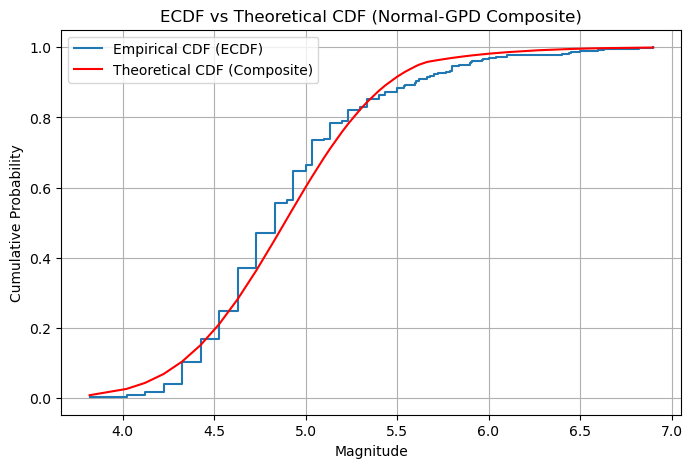

In [12]:
mu_norm, sigma_norm, xi_norm_gpd, sigma_norm_gpd = estimate_normal_gpd(data['mag'].values, u)

data['event rate'] = normal_comp_cdf(data['mag'] + e, mu_norm, sigma_norm, xi_norm_gpd, sigma_norm_gpd, u) - \
                     normal_comp_cdf(data['mag'] - e, mu_norm, sigma_norm, xi_norm_gpd, sigma_norm_gpd, u)

print(data.head())

# Plot ECDF vs Theoretical CDF
mag_sorted = np.sort(data['mag'])
ecdf = np.arange(1, len(mag_sorted)+1) / len(mag_sorted)
theoretical_cdf = normal_comp_cdf(mag_sorted, mu_norm, sigma_norm, xi_norm_gpd, sigma_norm_gpd, u)

plt.figure(figsize=(8,5))
plt.step(mag_sorted, ecdf, where='post', label='Empirical CDF (ECDF)')
plt.plot(mag_sorted, theoretical_cdf, 'r-', label='Theoretical CDF (Composite)')
plt.xlabel('Magnitude')
plt.ylabel('Cumulative Probability')
plt.title('ECDF vs Theoretical CDF (Normal-GPD Composite)')
plt.legend()
plt.grid(True)
plt.show()

# Burr-GPD

In [13]:
def log_likelihood_burr_gpd(params, data, u):
    theta, gamma, alpha, xi, sigma_gpd = params
    if theta <= 0 or gamma <= 0 or alpha <= 0 or sigma_gpd <= 0:
        return np.inf  # invalid parameter
    
    below_u = data[data < u]
    above_u = data[data >= u]
    
    # Burr part
    ll_burr = np.sum(
        np.log(alpha) + np.log(gamma) + gamma * np.log(below_u / theta)
        - np.log(below_u)
        - (alpha + 1) * np.log(1 + (below_u / theta) ** gamma)
    )
    
    # CDF Burr di u
    F_u = 1 - 1 / (1 + (u / theta) ** gamma) ** alpha
    
    # GPD part
    if xi != 0:
        ll_gpd = np.sum(
            np.log(1 - F_u) - np.log(sigma_gpd) +
            (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
        )
    else:
        ll_gpd = np.sum(
            np.log(1 - F_u) - np.log(sigma_gpd) -
            (above_u - u) / sigma_gpd
        )
    return -(ll_burr + ll_gpd)  # negative for minimization

def estimate_burr_gpd(data, u):
    theta0 = np.median(data[data < u])
    gamma0 = 1.5
    alpha0 = 2.0
    xi0 = 0.1
    sigma_gpd0 = np.std(data[data >= u])
    
    bounds = [
        (1e-6, None),      # theta (skala Burr)
        (1e-6, None),      # gamma (bentuk 1 Burr)
        (1e-6, None),      # alpha (bentuk 2 Burr)
        (-1, 1),           # xi (bentuk GPD)
        (1e-6, None)       # sigma_gpd (skala GPD)
    ]
    
    result = minimize(
        log_likelihood_burr_gpd,
        x0=[theta0, gamma0, alpha0, xi0, sigma_gpd0],
        args=(data, u),
        bounds=bounds,
        method='L-BFGS-B'
    )
    theta, gamma, alpha, xi, sigma_gpd = result.x
    print("Estimasi Parameter Burr-GPD")
    print("Parameter Burr:")
    print(f"\\theta (skala) = {theta:.4f}")
    print(f"\\gamma (bentuk 1) = {gamma:.4f}")
    print(f"\\alpha (bentuk 2) = {alpha:.4f}")
    print("Parameter GPD:")
    print(f"u (threshold) = {u:.4f}")
    print(f"\\xi (bentuk) = {xi:.4f}")
    print(f"\\sigma (skala) = {sigma_gpd:.4f}")
    return theta, gamma, alpha, xi, sigma_gpd

def burr_comp_cdf(x, theta, gamma, alpha, xi, sigma_gpd, u):
    # CDF komposit Burr-GPD
    F = 1 - 1 / (1 + (np.minimum(x, u) / theta) ** gamma) ** alpha
    if np.isscalar(x):
        if x < u:
            return F
        else:
            F_u = 1 - 1 / (1 + (u / theta) ** gamma) ** alpha
            if xi != 0:
                cdf_gpd = 1 - (1 - F_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi)
            else:
                cdf_gpd = 1 - (1 - F_u) * np.exp(-(x - u) / sigma_gpd)
            return cdf_gpd
    else:
        F_u = 1 - 1 / (1 + (u / theta) ** gamma) ** alpha
        cdf = np.where(
            x < u,
            F,
            np.where(
                xi != 0,
                1 - (1 - F_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi),
                1 - (1 - F_u) * np.exp(-(x - u) / sigma_gpd)
            )
        )
        return cdf

Estimasi Parameter Burr-GPD
Parameter Burr:
\theta (skala) = 5.0256
\gamma (bentuk 1) = 2.4492
\alpha (bentuk 2) = 1.9914
Parameter GPD:
u (threshold) = 5.6500
\xi (bentuk) = 0.0953
\sigma (skala) = 0.4511
                               time  latitude  longitude  depth   mag magType  \
0  2019-08-02 12:03:27.001000+00:00   -7.2822   104.7907   49.0  6.90      mw   
1  1954-07-03 22:31:27.020000+00:00   -6.6240   105.4470   60.0  6.82      mw   
2  1913-08-13 04:25:42.330000+00:00   -6.7460   105.2130   35.0  6.63      mw   
3  2022-01-14 09:05:41.461000+00:00   -6.8600   105.2887   33.0  6.60      mw   
4  1999-12-21 14:14:57.610000+00:00   -6.8450   105.5550   56.0  6.50      mw   

   nst   gap   dmin   rms  ... depthError magError magNst    status  \
0  NaN  23.0  2.839  0.76  ...        1.9    0.043   51.0  reviewed   
1  NaN   NaN    NaN   NaN  ...        5.2    0.430    NaN  reviewed   
2  NaN   NaN    NaN   NaN  ...       30.2    0.230    NaN  reviewed   
3  NaN  22.0  2.418  0.

C:\Users\user\AppData\Local\Temp\ipykernel_7212\666777911.py:23: RuntimeWarning: invalid value encountered in log
  (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)


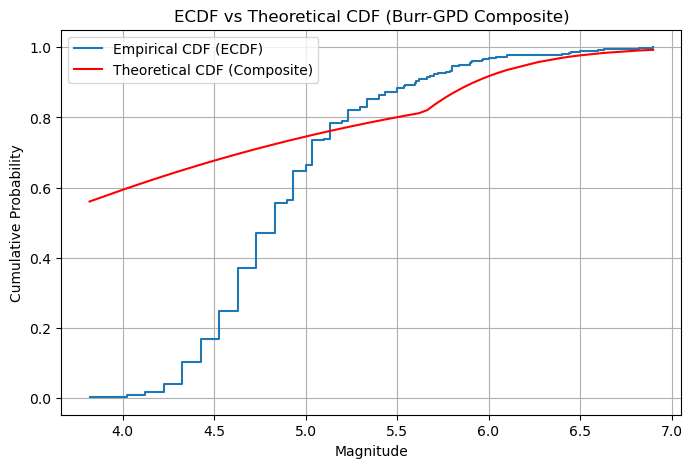

In [14]:
theta_burr, gamma_burr, alpha_burr, xi_burr_gpd, sigma_burr_gpd = estimate_burr_gpd(data['mag'].values, u)

data['event rate'] = burr_comp_cdf(data['mag'] + e, theta_burr, gamma_burr, alpha_burr, xi_burr_gpd, sigma_burr_gpd, u) - \
                     burr_comp_cdf(data['mag'] - e, theta_burr, gamma_burr, alpha_burr, xi_burr_gpd, sigma_burr_gpd, u)

print(data.head())

# Plot ECDF vs Theoretical CDF
mag_sorted = np.sort(data['mag'])
ecdf = np.arange(1, len(mag_sorted)+1) / len(mag_sorted)
theoretical_cdf = burr_comp_cdf(mag_sorted, theta_burr, gamma_burr, alpha_burr, xi_burr_gpd, sigma_burr_gpd, u)

plt.figure(figsize=(8,5))
plt.step(mag_sorted, ecdf, where='post', label='Empirical CDF (ECDF)')
plt.plot(mag_sorted, theoretical_cdf, 'r-', label='Theoretical CDF (Composite)')
plt.xlabel('Magnitude')
plt.ylabel('Cumulative Probability')
plt.title('ECDF vs Theoretical CDF (Burr-GPD Composite)')
plt.legend()
plt.grid(True)
plt.show()

# Exponential-GPD

In [15]:
def log_likelihood_exp_gpd(params, data, u):
    theta, xi, sigma_gpd = params
    if theta <= 0 or sigma_gpd <= 0:
        return np.inf  # invalid parameter
    
    below_u = data[data < u]
    above_u = data[data >= u]
    
    # Eksponensial part
    ll_exp = np.sum(-np.log(theta) - below_u / theta)
    
    # GPD part
    exp_cdf_u = 1 - np.exp(-u / theta)
    if xi != 0:
        ll_gpd = np.sum(
            np.log(1 - exp_cdf_u) - np.log(sigma_gpd) +
            (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
        )
    else:
        ll_gpd = np.sum(
            np.log(1 - exp_cdf_u) - np.log(sigma_gpd) -
            (above_u - u) / sigma_gpd
        )
    return -(ll_exp + ll_gpd)  # negative for minimization

def estimate_exp_gpd(data, u):
    theta0 = np.mean(data[data < u])
    xi0 = 0.1
    sigma_gpd0 = np.std(data[data >= u])
    
    bounds = [
        (1e-6, None),      # theta (skala Eksponensial)
        (-1, 1),           # xi (bentuk GPD)
        (1e-6, None)       # sigma_gpd (skala GPD)
    ]
    
    result = minimize(
        log_likelihood_exp_gpd,
        x0=[theta0, xi0, sigma_gpd0],
        args=(data, u),
        bounds=bounds,
        method='L-BFGS-B'
    )
    theta, xi, sigma_gpd = result.x
    print("Estimasi Parameter Eksponensial-GPD")
    print("Parameter Eksponensial:")
    print(f"\\theta (skala) = {theta:.4f}")
    print("Parameter GPD:")
    print(f"u (threshold) = {u:.4f}")
    print(f"\\xi (bentuk) = {xi:.4f}")
    print(f"\\sigma (skala) = {sigma_gpd:.4f}")
    return theta, xi, sigma_gpd

def exp_comp_cdf(x, theta, xi, sigma_gpd, u):
    # CDF komposit Eksponensial-GPD
    exp_cdf = 1 - np.exp(-np.minimum(x, u) / theta)
    if np.isscalar(x):
        if x < u:
            return exp_cdf
        else:
            cdf_u = 1 - np.exp(-u / theta)
            if xi != 0:
                cdf_gpd = 1 - (1 - cdf_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi)
            else:
                cdf_gpd = 1 - (1 - cdf_u) * np.exp(-(x - u) / sigma_gpd)
            return cdf_gpd
    else:
        cdf_u = 1 - np.exp(-u / theta)
        cdf = np.where(
            x < u,
            exp_cdf,
            np.where(
                xi != 0,
                1 - (1 - cdf_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi),
                1 - (1 - cdf_u) * np.exp(-(x - u) / sigma_gpd)
            )
        )
        return cdf

Estimasi Parameter Eksponensial-GPD
Parameter Eksponensial:
\theta (skala) = 5.3579
Parameter GPD:
u (threshold) = 5.6500
\xi (bentuk) = 0.1724
\sigma (skala) = 0.4426
                               time  latitude  longitude  depth   mag magType  \
0  2019-08-02 12:03:27.001000+00:00   -7.2822   104.7907   49.0  6.90      mw   
1  1954-07-03 22:31:27.020000+00:00   -6.6240   105.4470   60.0  6.82      mw   
2  1913-08-13 04:25:42.330000+00:00   -6.7460   105.2130   35.0  6.63      mw   
3  2022-01-14 09:05:41.461000+00:00   -6.8600   105.2887   33.0  6.60      mw   
4  1999-12-21 14:14:57.610000+00:00   -6.8450   105.5550   56.0  6.50      mw   

   nst   gap   dmin   rms  ... depthError magError magNst    status  \
0  NaN  23.0  2.839  0.76  ...        1.9    0.043   51.0  reviewed   
1  NaN   NaN    NaN   NaN  ...        5.2    0.430    NaN  reviewed   
2  NaN   NaN    NaN   NaN  ...       30.2    0.230    NaN  reviewed   
3  NaN  22.0  2.418  0.54  ...        1.7    0.063   24.0  re

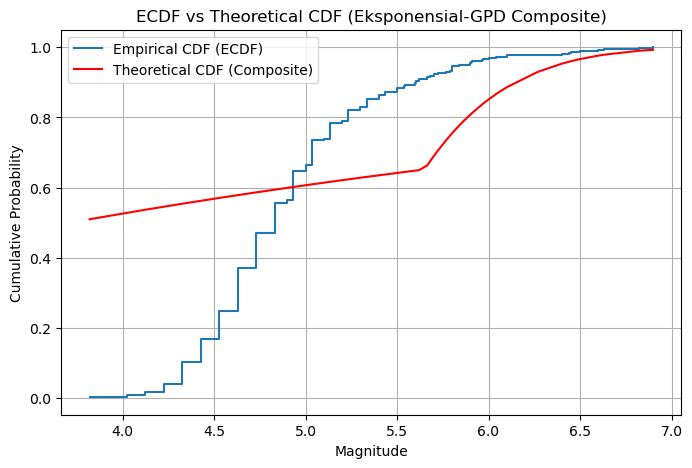

In [16]:
theta_exp, xi_exp_gpd, sigma_exp_gpd = estimate_exp_gpd(data['mag'].values, u)

e = 0.00001
data['event rate'] = exp_comp_cdf(data['mag'] + e, theta_exp, xi_exp_gpd, sigma_exp_gpd, u) - \
                     exp_comp_cdf(data['mag'] - e, theta_exp, xi_exp_gpd, sigma_exp_gpd, u)

print(data.head())

# Plot ECDF vs Theoretical CDF
mag_sorted = np.sort(data['mag'])
ecdf = np.arange(1, len(mag_sorted)+1) / len(mag_sorted)
theoretical_cdf = exp_comp_cdf(mag_sorted, theta_exp, xi_exp_gpd, sigma_exp_gpd, u)

plt.figure(figsize=(8,5))
plt.step(mag_sorted, ecdf, where='post', label='Empirical CDF (ECDF)')
plt.plot(mag_sorted, theoretical_cdf, 'r-', label='Theoretical CDF (Composite)')
plt.xlabel('Magnitude')
plt.ylabel('Cumulative Probability')
plt.title('ECDF vs Theoretical CDF (Eksponensial-GPD Composite)')
plt.legend()
plt.grid(True)
plt.show()

# Generalized Beta-GPD

In [17]:
def log_likelihood_gbeta_gpd(params, data, u):
    a, b, p, q, xi, sigma_gpd = params
    if a <= 0 or b <= 0 or p <= 0 or q <= 0 or sigma_gpd <= 0:
        return np.inf  # invalid parameter

    below_u = data[data < u]
    above_u = data[data >= u]

    # Generalized Beta part (PDF)
    ll_gbeta = np.sum(
        betaln(p + q, 1) - betaln(p, q) +
        np.log(a) + (a * p - 1) * np.log(below_u / b) -
        np.log(below_u) - (p + q) * np.log(1 + (below_u / b) ** a)
    )

    # CDF Generalized Beta di u
    t_u = (u / b) ** a / (1 + (u / b) ** a)
    F_u = betainc(p, q, t_u)

    # GPD part
    if xi != 0:
        ll_gpd = np.sum(
            np.log(1 - F_u) - np.log(sigma_gpd) +
            (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)
        )
    else:
        ll_gpd = np.sum(
            np.log(1 - F_u) - np.log(sigma_gpd) -
            (above_u - u) / sigma_gpd
        )
    return -(ll_gbeta + ll_gpd)  # negative for minimization

def estimate_gbeta_gpd(data, u):
    a0 = 1.5
    b0 = np.median(data[data < u])
    p0 = 2.0
    q0 = 2.0
    xi0 = 0.1
    sigma_gpd0 = np.std(data[data >= u])

    bounds = [
        (1e-6, None),      # a (bentuk 1)
        (1e-6, None),      # b (skala)
        (1e-6, None),      # p (bentuk 2)
        (1e-6, None),      # q (bentuk 3)
        (-1, 1),           # xi (bentuk GPD)
        (1e-6, None)       # sigma_gpd (skala GPD)
    ]

    result = minimize(
        log_likelihood_gbeta_gpd,
        x0=[a0, b0, p0, q0, xi0, sigma_gpd0],
        args=(data, u),
        bounds=bounds,
        method='L-BFGS-B'
    )
    a, b, p, q, xi, sigma_gpd = result.x
    print("Estimasi Parameter Generalized Beta-GPD")
    print("Parameter Generalized Beta:")
    print(f"\\a (bentuk 1) = {a:.4f}")
    print(f"\\b (skala) = {b:.4f}")
    print(f"\\p (bentuk 2) = {p:.4f}")
    print(f"\\q (bentuk 3) = {q:.4f}")
    print("Parameter GPD:")
    print(f"u (threshold) = {u:.4f}")
    print(f"\\xi (bentuk) = {xi:.4f}")
    print(f"\\sigma (skala) = {sigma_gpd:.4f}")
    return a, b, p, q, xi, sigma_gpd

def gbeta_comp_cdf(x, a, b, p, q, xi, sigma_gpd, u):
    # CDF komposit Generalized Beta-GPD
    t = (np.minimum(x, u) / b) ** a / (1 + (np.minimum(x, u) / b) ** a)
    F = betainc(p, q, t)
    if np.isscalar(x):
        if x < u:
            return F
        else:
            t_u = (u / b) ** a / (1 + (u / b) ** a)
            F_u = betainc(p, q, t_u)
            if xi != 0:
                cdf_gpd = 1 - (1 - F_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi)
            else:
                cdf_gpd = 1 - (1 - F_u) * np.exp(-(x - u) / sigma_gpd)
            return cdf_gpd
    else:
        t_u = (u / b) ** a / (1 + (u / b) ** a)
        F_u = betainc(p, q, t_u)
        cdf = np.where(
            x < u,
            F,
            np.where(
                xi != 0,
                1 - (1 - F_u) * (1 - xi * (x - u) / sigma_gpd) ** (1 / xi),
                1 - (1 - F_u) * np.exp(-(x - u) / sigma_gpd)
            )
        )
        return cdf

C:\Users\user\AppData\Local\Temp\ipykernel_7212\2039978715.py:24: RuntimeWarning: invalid value encountered in log
  (1/xi - 1) * np.log(1 - xi * (above_u - u) / sigma_gpd)


Estimasi Parameter Generalized Beta-GPD
Parameter Generalized Beta:
\a (bentuk 1) = 2.4294
\b (skala) = 5.0837
\p (bentuk 2) = 1.9917
\q (bentuk 3) = 1.9917
Parameter GPD:
u (threshold) = 5.6500
\xi (bentuk) = 0.0954
\sigma (skala) = 0.4477
                               time  latitude  longitude  depth   mag magType  \
0  2019-08-02 12:03:27.001000+00:00   -7.2822   104.7907   49.0  6.90      mw   
1  1954-07-03 22:31:27.020000+00:00   -6.6240   105.4470   60.0  6.82      mw   
2  1913-08-13 04:25:42.330000+00:00   -6.7460   105.2130   35.0  6.63      mw   
3  2022-01-14 09:05:41.461000+00:00   -6.8600   105.2887   33.0  6.60      mw   
4  1999-12-21 14:14:57.610000+00:00   -6.8450   105.5550   56.0  6.50      mw   

   nst   gap   dmin   rms  ... depthError magError magNst    status  \
0  NaN  23.0  2.839  0.76  ...        1.9    0.043   51.0  reviewed   
1  NaN   NaN    NaN   NaN  ...        5.2    0.430    NaN  reviewed   
2  NaN   NaN    NaN   NaN  ...       30.2    0.230    NaN  

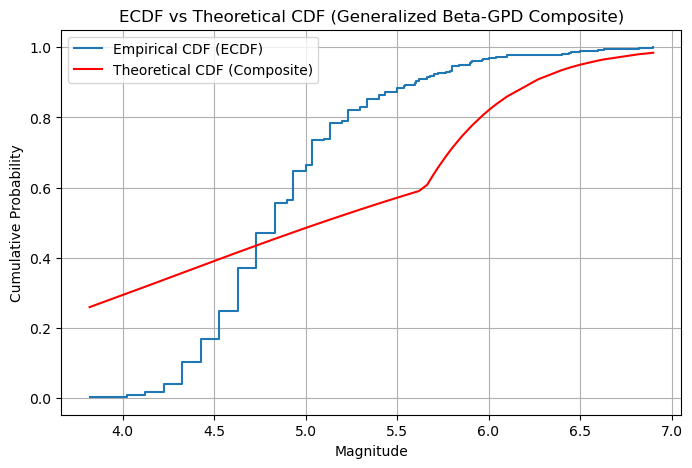

In [18]:
a, b, p, q, xi_gb_gpd, sigma_gb_gpd = estimate_gbeta_gpd(data['mag'].values, u)

data['event rate'] = gbeta_comp_cdf(data['mag'] + e, a, b, p, q, xi_gb_gpd, sigma_gb_gpd, u) - \
                     gbeta_comp_cdf(data['mag'] - e, a, b, p, q, xi_gb_gpd, sigma_gb_gpd, u)

print(data.head())

# Plot ECDF vs Theoretical CDF
mag_sorted = np.sort(data['mag'])
ecdf = np.arange(1, len(mag_sorted)+1) / len(mag_sorted)
theoretical_cdf = gbeta_comp_cdf(mag_sorted, a, b, p, q, xi_gb_gpd, sigma_gb_gpd, u)

plt.figure(figsize=(8,5))
plt.step(mag_sorted, ecdf, where='post', label='Empirical CDF (ECDF)')
plt.plot(mag_sorted, theoretical_cdf, 'r-', label='Theoretical CDF (Composite)')
plt.xlabel('Magnitude')
plt.ylabel('Cumulative Probability')
plt.title('ECDF vs Theoretical CDF (Generalized Beta-GPD Composite)')
plt.legend()
plt.grid(True)
plt.show()

# Theoretical CDF vs ECDF

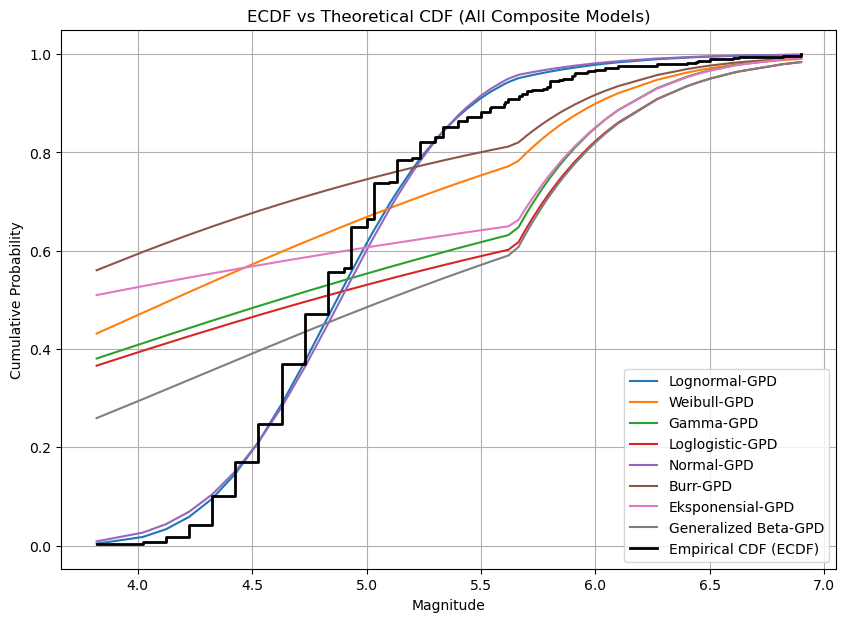

In [19]:
plt.figure(figsize=(10,7))

# Lognormal-GPD
theoretical_cdf_logn = logn_comp_cdf(mag_sorted, mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd, u)
plt.plot(mag_sorted, theoretical_cdf_logn, label='Lognormal-GPD')

# Weibull-GPD
theoretical_cdf_weibull = weibull_comp_cdf(mag_sorted, theta_wei, tau_wei, xi_wei_gpd, sigma_wei_gpd, u)
plt.plot(mag_sorted, theoretical_cdf_weibull, label='Weibull-GPD')

# Gamma-GPD
theoretical_cdf_gamma = gamma_comp_cdf(mag_sorted, theta_gam, alpha_gam, xi_gam_gpd, sigma_gam_gpd, u)
plt.plot(mag_sorted, theoretical_cdf_gamma, label='Gamma-GPD')

# Loglogistic-GPD
theoretical_cdf_loglog = loglogistic_comp_cdf(mag_sorted, theta_logl, gamma_logl, xi_logl_gpd, sigma_logl_gpd, u)
plt.plot(mag_sorted, theoretical_cdf_loglog, label='Loglogistic-GPD')

# Normal-GPD
theoretical_cdf_normal = normal_comp_cdf(mag_sorted, mu_norm, sigma_norm, xi_norm_gpd, sigma_norm_gpd, u)
plt.plot(mag_sorted, theoretical_cdf_normal, label='Normal-GPD')

# Burr-GPD
theoretical_cdf_burr = burr_comp_cdf(mag_sorted, theta_burr, gamma_burr, alpha_burr, xi_burr_gpd, sigma_burr_gpd, u)
plt.plot(mag_sorted, theoretical_cdf_burr, label='Burr-GPD')

# Exponential-GPD
theoretical_cdf_exp = exp_comp_cdf(mag_sorted, theta_exp, xi_exp_gpd, sigma_exp_gpd, u)
plt.plot(mag_sorted, theoretical_cdf_exp, label='Eksponensial-GPD')

# Generalized Beta-GPD
theoretical_cdf_gbeta = gbeta_comp_cdf(mag_sorted, a, b, p, q, xi_gb_gpd, sigma_gb_gpd, u)
plt.plot(mag_sorted, theoretical_cdf_gbeta, label='Generalized Beta-GPD')

# ECDF
plt.step(mag_sorted, ecdf, where='post', color='k', label='Empirical CDF (ECDF)', linewidth=2)

plt.xlabel('Magnitude')
plt.ylabel('Cumulative Probability')
plt.title('ECDF vs Theoretical CDF (All Composite Models)')
plt.legend()
plt.grid(True)
plt.show()

# KS, AD, and CvM Test

In [20]:
# Helper: log-likelihood untuk AIC/BIC
def log_likelihood_from_cdf(cdf_func, params, data, u):
    e = 1e-8
    cdf_plus = cdf_func(data + e, *params, u)
    cdf_minus = cdf_func(data - e, *params, u)
    pdf = cdf_plus - cdf_minus
    pdf = np.clip(pdf, 1e-12, None)
    return np.sum(np.log(pdf))

# Model list
models = [
    {
        "name": "Lognormal",
        "cdf": logn_comp_cdf,
        "params": (mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd),
        "k": 4
    },
    {
        "name": "Weibull",
        "cdf": weibull_comp_cdf,
        "params": (theta_wei, tau_wei, xi_wei_gpd, sigma_wei_gpd),
        "k": 4
    },
    {
        "name": "Gamma",
        "cdf": gamma_comp_cdf,
        "params": (theta_gam, alpha_gam, xi_gam_gpd, sigma_gam_gpd),
        "k": 4
    },
    {
        "name": "Loglogistic",
        "cdf": loglogistic_comp_cdf,
        "params": (theta_logl, gamma_logl, xi_logl_gpd, sigma_logl_gpd),
        "k": 4
    },
    {
        "name": "Normal",
        "cdf": normal_comp_cdf,
        "params": (mu_norm, sigma_norm, xi_norm_gpd, sigma_norm_gpd),
        "k": 4
    },
    {
        "name": "Burr",
        "cdf": burr_comp_cdf,
        "params": (theta_burr, gamma_burr, alpha_burr, xi_burr_gpd, sigma_burr_gpd),
        "k": 5
    },
    {
        "name": "Exponential",
        "cdf": exp_comp_cdf,
        "params": (theta_exp, xi_exp_gpd, sigma_exp_gpd),
        "k": 3
    },
    {
        "name": "Generalized Beta",
        "cdf": gbeta_comp_cdf,
        "params": (a, b, p, q, xi_gb_gpd, sigma_gb_gpd),
        "k": 6
    }
]

results = []
n = len(data['mag'])

for m in models:
    # Theoretical CDF
    cdf_vals = m["cdf"](data['mag'].values, *m["params"], u)
    # KS test
    ks_stat, ks_p = kstest(data['mag'].values, lambda x: m["cdf"](x, *m["params"], u))
    # Anderson-Darling (approximate, using anderson_ksamp)
    ad_result = anderson_ksamp([data['mag'].values, cdf_vals])
    ad_stat = ad_result.statistic
    ad_p = ad_result.significance_level / 100  # convert to 0-1
    # Cramer-von Mises
    cvm_result = cramervonmises(data['mag'].values, lambda x: m["cdf"](x, *m["params"], u))
    cvm_stat = cvm_result.statistic
    cvm_p = cvm_result.pvalue
    # Log-likelihood, AIC, BIC
    ll = log_likelihood_from_cdf(m["cdf"], m["params"], data['mag'].values, u)
    aic = 2 * m["k"] - 2 * ll
    bic = m["k"] * np.log(n) - 2 * ll
    results.append([
        m["name"], ks_stat, ks_p, ad_stat, ad_p, cvm_stat, cvm_p, aic, bic
    ])

# Buat DataFrame
columns = [
    "Model Bulk", "KS Stat", "KS P-value", "AD Stat", "AD P-value",
    "CvM Stat", "CvM P-value", "AIC", "BIC"
]
df = pd.DataFrame(results, columns=columns)
print(df)

# Pemilihan Model
print("\nPemilihan Model")
print(f"Statistik KS terkecil = {df.loc[df['KS Stat'].idxmin(), 'Model Bulk']} ({df['KS Stat'].min():.4f})")
print(f"P-value KS terbesar = {df.loc[df['KS P-value'].idxmax(), 'Model Bulk']} ({df['KS P-value'].max():.4f})")
print(f"Statistik AD terkecil = {df.loc[df['AD Stat'].idxmin(), 'Model Bulk']} ({df['AD Stat'].min():.4f})")
print(f"P-value AD terbesar = {df.loc[df['AD P-value'].idxmax(), 'Model Bulk']} ({df['AD P-value'].max():.4f})")
print(f"Statistik CvM terkecil = {df.loc[df['CvM Stat'].idxmin(), 'Model Bulk']} ({df['CvM Stat'].min():.4f})")
print(f"P-value CvM terbesar = {df.loc[df['CvM P-value'].idxmax(), 'Model Bulk']} ({df['CvM P-value'].max():.4f})")
print(f"AIC terkecil = {df.loc[df['AIC'].idxmin(), 'Model Bulk']} ({df['AIC'].min():.4f})")
print(f"BIC terkecil = {df.loc[df['BIC'].idxmin(), 'Model Bulk']} ({df['BIC'].min():.4f})")

         Model Bulk   KS Stat     KS P-value     AD Stat  AD P-value  \
0         Lognormal  0.097629   1.226515e-03  405.159217     0.00001   
1           Weibull  0.497668   2.064888e-88  405.159217     0.00001   
2             Gamma  0.424310   3.110314e-63  405.159217     0.00001   
3       Loglogistic  0.407768   3.147359e-58  405.159217     0.00001   
4            Normal  0.108791   2.059234e-04  405.159217     0.00001   
5              Burr  0.614383  6.169577e-140  405.159217     0.00001   
6       Exponential  0.528945  9.822017e-101  405.159217     0.00001   
7  Generalized Beta  0.318847   3.215289e-35  405.159217     0.00001   

    CvM Stat   CvM P-value           AIC           BIC  
0   0.660171  1.587590e-02  14120.523426  14136.325996  
1  24.572670  2.261579e-09  14892.800540  14908.603110  
2  18.921199  5.000732e-09  15073.755798  15089.558369  
3  18.824073  4.603926e-09  15116.358901  15132.161471  
4   0.948403  3.228717e-03  14142.601998  14158.404569  
5  40.397

C:\Users\user\AppData\Local\Temp\ipykernel_7212\3364977522.py:71: UserWarning: p-value floored: true value smaller than 0.001
  ad_result = anderson_ksamp([data['mag'].values, cdf_vals])


# Kernel-GPD

C:\Users\user\AppData\Local\Temp\ipykernel_7212\4167543124.py:46: RuntimeWarning: divide by zero encountered in log
  ll_gpd = np.sum(np.log(1 - H_u) + np.log(gpd))
c:\Users\user\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Parameter Kernel:
- Bandwidth (scott's rule): 0.31005226949548037
Parameter GPD:
- u (treshold) = 5.6500
- xi (bentuk) = 0.1000
- sigma (skala) = 0.3458

Statistik KS = 0.1057
P-value KS = 0.0003
Statistik AD = 407.0132
P-value AD = 0.0000
Statistik CvM = 1.3410
P-value CvM = 0.0004
AIC = inf
BIC = inf


C:\Users\user\AppData\Local\Temp\ipykernel_7212\4167543124.py:89: UserWarning: p-value floored: true value smaller than 0.001
  ad_result = anderson_ksamp([x, cdf_vals])
C:\Users\user\AppData\Local\Temp\ipykernel_7212\4167543124.py:105: RuntimeWarning: divide by zero encountered in log
  ll_gpd = np.sum(np.log(1 - H_u) + np.log(gpd))


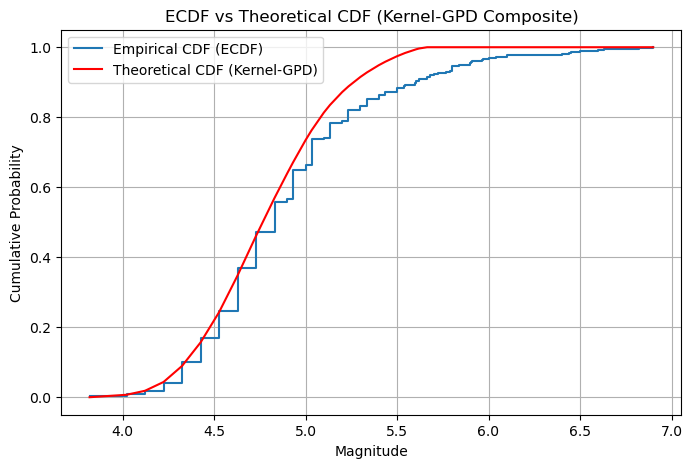

In [21]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde, kstest, cramervonmises, anderson_ksamp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Data dan threshold
x = data['mag'].values
u = 5.65

# Kernel PDF dan CDF
kde = gaussian_kde(x[x < u])
def kernel_pdf(val):
    return kde(val)
def kernel_cdf(val):
    # Numerik CDF dari KDE
    grid = np.linspace(x.min(), u, 1000)
    cdf_vals = np.cumsum(kde(grid))
    cdf_vals /= cdf_vals[-1]
    return np.interp(val, grid, cdf_vals)

# GPD PDF
def gpd_pdf(y, xi, sigma):
    if sigma <= 0:
        return np.zeros_like(y)
    if np.abs(xi) > 1e-6:
        return (1/sigma) * (1 + xi * y / sigma) ** (-1/xi - 1) * (y >= 0)
    else:
        return (1/sigma) * np.exp(-y/sigma) * (y >= 0)

# Log-likelihood Kernel-GPD
def log_likelihood_kernel_gpd(params, x, u):
    xi, sigma = params
    if sigma <= 0:
        return np.inf
    below = x[x < u]
    above = x[x >= u]
    # Kernel part
    ll_kernel = np.sum(np.log(kernel_pdf(below)))
    # GPD part
    H_u = kernel_cdf(u)
    y = above - u
    gpd = gpd_pdf(y, xi, sigma)
    # Hindari log(0)
    gpd = np.clip(gpd, 1e-12, None)
    ll_gpd = np.sum(np.log(1 - H_u) + np.log(gpd))
    return -(ll_kernel + ll_gpd)

# Estimasi parameter
xi0 = 0.1
sigma0 = np.std(x[x >= u])
result = minimize(
    log_likelihood_kernel_gpd,
    x0=[xi0, sigma0],
    args=(x, u),
    bounds=[(-1, 1), (1e-6, None)],
    method='L-BFGS-B'
)
xi_hat, sigma_hat = result.x

print("Parameter Kernel:")
print("- Bandwidth (scott's rule):", kde.factor)
print("Parameter GPD:")
print(f"- u (treshold) = {u:.4f}")
print(f"- xi (bentuk) = {xi_hat:.4f}")
print(f"- sigma (skala) = {sigma_hat:.4f}")

# Composite CDF
def kernel_gpd_comp_cdf(val, xi, sigma, u):
    val = np.asarray(val)
    cdf = np.zeros_like(val)
    H_u = kernel_cdf(u)
    # Kernel part
    mask_below = val < u
    cdf[mask_below] = kernel_cdf(val[mask_below])
    # GPD part
    mask_above = val >= u
    y = val[mask_above] - u
    if np.abs(xi) > 1e-6:
        G = 1 - (1 + xi * y / sigma) ** (-1/xi)
    else:
        G = 1 - np.exp(-y / sigma)
    cdf[mask_above] = H_u + (1 - H_u) * G
    return cdf

# Goodness-of-fit
cdf_vals = kernel_gpd_comp_cdf(x, xi_hat, sigma_hat, u)
ks_stat, ks_p = kstest(x, lambda v: kernel_gpd_comp_cdf(v, xi_hat, sigma_hat, u))
ad_result = anderson_ksamp([x, cdf_vals])
ad_stat = ad_result.statistic
ad_p = ad_result.significance_level / 100
cvm_result = cramervonmises(x, lambda v: kernel_gpd_comp_cdf(v, xi_hat, sigma_hat, u))
cvm_stat = cvm_result.statistic
cvm_p = cvm_result.pvalue

# Log-likelihood, AIC, BIC
def log_likelihood_kernel_gpd_full(x, xi, sigma, u):
    below = x[x < u]
    above = x[x >= u]
    ll_kernel = np.sum(np.log(kernel_pdf(below)))
    H_u = kernel_cdf(u)
    y = above - u
    gpd = gpd_pdf(y, xi, sigma)
    gpd = np.clip(gpd, 1e-12, None)
    ll_gpd = np.sum(np.log(1 - H_u) + np.log(gpd))
    return ll_kernel + ll_gpd

ll = log_likelihood_kernel_gpd_full(x, xi_hat, sigma_hat, u)
k = 2  # xi, sigma
n = len(x)
aic = 2 * k - 2 * ll
bic = k * np.log(n) - 2 * ll

print(f"\nStatistik KS = {ks_stat:.4f}")
print(f"P-value KS = {ks_p:.4f}")
print(f"Statistik AD = {ad_stat:.4f}")
print(f"P-value AD = {ad_p:.4f}")
print(f"Statistik CvM = {cvm_stat:.4f}")
print(f"P-value CvM = {cvm_p:.4f}")
print(f"AIC = {aic:.4f}")
print(f"BIC = {bic:.4f}")

# Plot ECDF vs Theoretical CDF
mag_sorted = np.sort(x)
ecdf = np.arange(1, len(mag_sorted)+1) / len(mag_sorted)
theoretical_cdf = kernel_gpd_comp_cdf(mag_sorted, xi_hat, sigma_hat, u)

plt.figure(figsize=(8,5))
plt.step(mag_sorted, ecdf, where='post', label='Empirical CDF (ECDF)')
plt.plot(mag_sorted, theoretical_cdf, 'r-', label='Theoretical CDF (Kernel-GPD)')
plt.xlabel('Magnitude')
plt.ylabel('Cumulative Probability')
plt.title('ECDF vs Theoretical CDF (Kernel-GPD Composite)')
plt.legend()
plt.grid(True)
plt.show()

# Best ECDF vs TCDF

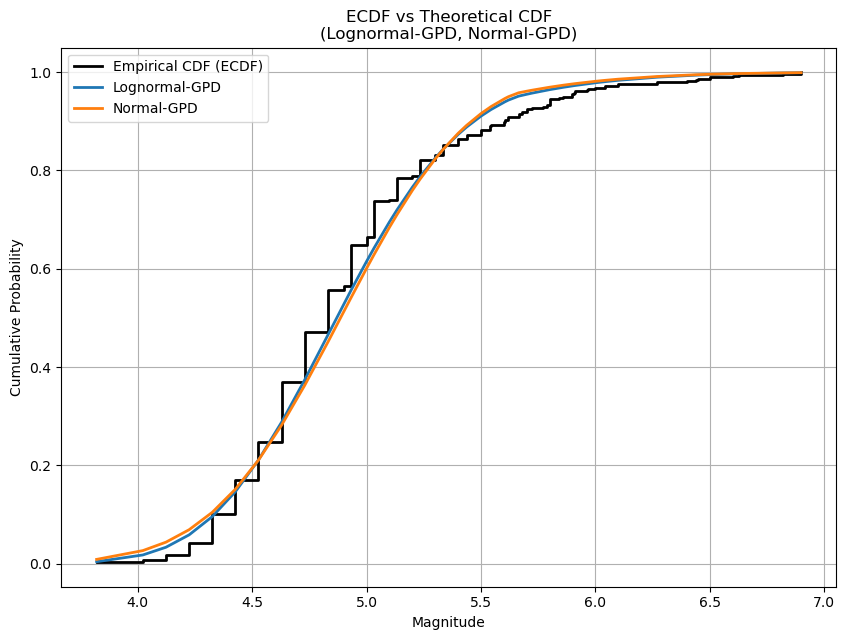

In [22]:
plt.figure(figsize=(10,7))

# ECDF
mag_sorted = np.sort(data['mag'])
ecdf = np.arange(1, len(mag_sorted)+1) / len(mag_sorted)
plt.step(mag_sorted, ecdf, where='post', color='k', label='Empirical CDF (ECDF)', linewidth=2)

# Lognormal-GPD
theoretical_cdf_logn = logn_comp_cdf(mag_sorted, mu_logn, sigma_logn, xi_logn_gpd, sigma_logn_gpd, u)
plt.plot(mag_sorted, theoretical_cdf_logn, label='Lognormal-GPD', linewidth=2)

# Normal-GPD
theoretical_cdf_normal = normal_comp_cdf(mag_sorted, mu_norm, sigma_norm, xi_norm_gpd, sigma_norm_gpd, u)
plt.plot(mag_sorted, theoretical_cdf_normal, label='Normal-GPD', linewidth=2)

plt.xlabel('Magnitude')
plt.ylabel('Cumulative Probability')
plt.title('ECDF vs Theoretical CDF\n(Lognormal-GPD, Normal-GPD)')
plt.legend()
plt.grid(True)
plt.show()

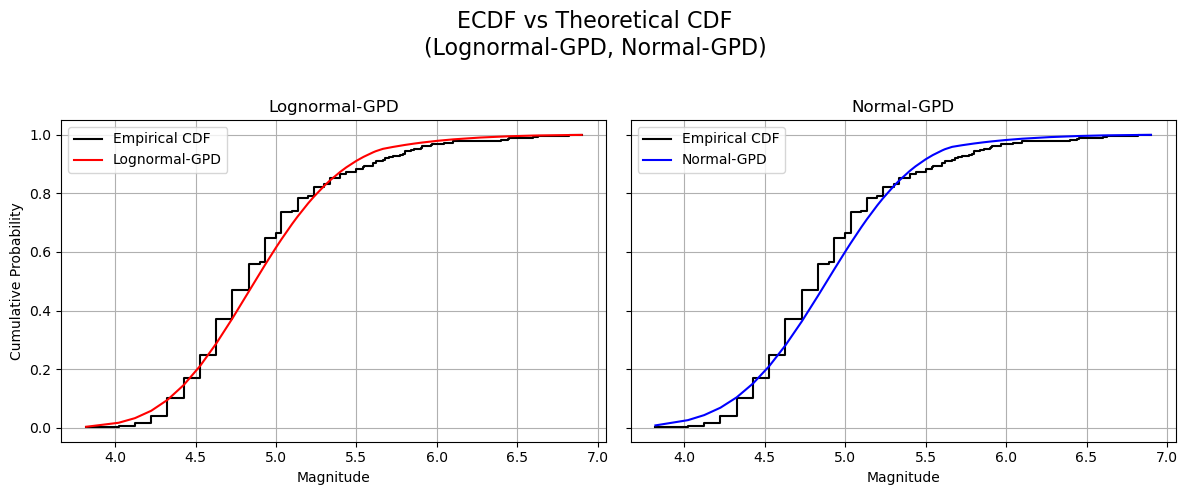

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

mag_sorted = np.sort(data['mag'])
ecdf = np.arange(1, len(mag_sorted)+1) / len(mag_sorted)

# Lognormal-GPD
axs[0].step(mag_sorted, ecdf, where='post', color='k', label='Empirical CDF')
axs[0].plot(mag_sorted, theoretical_cdf_logn, 'r-', label='Lognormal-GPD')
axs[0].set_title('Lognormal-GPD')
axs[0].set_xlabel('Magnitude')
axs[0].set_ylabel('Cumulative Probability')
axs[0].legend()
axs[0].grid(True)

# Normal-GPD
axs[1].step(mag_sorted, ecdf, where='post', color='k', label='Empirical CDF')
axs[1].plot(mag_sorted, theoretical_cdf_normal, 'b-', label='Normal-GPD')
axs[1].set_title('Normal-GPD')
axs[1].set_xlabel('Magnitude')
axs[1].legend()
axs[1].grid(True)

plt.suptitle('ECDF vs Theoretical CDF\n(Lognormal-GPD, Normal-GPD)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()